In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torchvision
from torchvision import datasets, transforms, utils
import torchvision.models as models
from tqdm import tqdm
from PIL import Image

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler

import copy
import random
import time

In [2]:
torch.__version__

'1.9.0'

In [67]:
mean = 0.5
std = 0.5

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=3),
                               transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                               ])

transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     torchvision.transforms.Grayscale(num_output_channels=3),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

trainset = datasets.ImageFolder(root="/Users/Hanbit/Desktop/damage_class/train",
                                transform = transform)
testset = datasets.ImageFolder(root="/Users/Hanbit/Desktop/damage_class/test",
                                transform = transform_test)

# testset = datasets.ImageFolder(root="/cars_84/test",
#                                transform = transform)

In [68]:
len(trainset)

436

In [69]:
trainset.__getitem__(10)

(tensor([[[-0.3476, -0.4694, -0.3566,  ..., -0.2485, -0.2363, -0.2363],
          [-0.4090, -0.3476, -0.3294,  ..., -0.2485, -0.2363, -0.2534],
          [-0.4192, -0.2791, -0.3224,  ..., -0.2585, -0.2534, -0.2534],
          ...,
          [ 0.3996,  0.3482,  0.3925,  ..., -1.8438, -1.8386, -1.8386],
          [ 0.3695,  0.3524,  0.3353,  ..., -1.8572, -1.8400, -1.8400],
          [ 0.3695,  0.3524,  0.3353,  ..., -1.8572, -1.8400, -1.8400]],
 
         [[-0.2259, -0.3504, -0.2351,  ..., -0.1246, -0.1121, -0.1121],
          [-0.2887, -0.2259, -0.2073,  ..., -0.1246, -0.1121, -0.1296],
          [-0.2991, -0.1559, -0.2001,  ..., -0.1349, -0.1296, -0.1296],
          ...,
          [ 0.5380,  0.4855,  0.5307,  ..., -1.7554, -1.7502, -1.7502],
          [ 0.5072,  0.4897,  0.4722,  ..., -1.7691, -1.7516, -1.7516],
          [ 0.5072,  0.4897,  0.4722,  ..., -1.7691, -1.7516, -1.7516]],
 
         [[-0.0027, -0.1266, -0.0118,  ...,  0.0982,  0.1106,  0.1106],
          [-0.0652, -0.0027,

In [70]:
classes = trainset.classes
classes

['damaged', 'no_damaged']

In [71]:
len(classes)

2

In [72]:
batch_size = 2

In [73]:
trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size = batch_size,
                                              shuffle = True,
                                              num_workers = 2)


In [74]:
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                        shuffle = True,
                                        num_workers = 2)

In [75]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [76]:
def imshow(img):
    img = img/2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    
    print(np_img.shape)
    print((np.transpose(np_img,(1,2,0))).shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 224, 224])
(3, 228, 454)
(228, 454, 3)


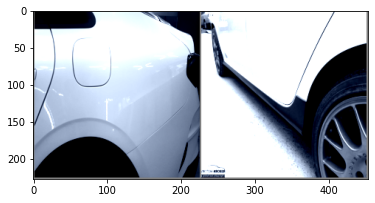

In [77]:
print(images.shape)
imshow(torchvision.utils.make_grid(images,nrow=4))

## Transfer Learning

### Renset50

In [78]:
resnet = models.resnet50(pretrained = True)

In [79]:
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [80]:
list(resnet.children())[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [81]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:-3])
        self.layer1 = nn.Sequential(*list(resnet.children())[-3:-1])
        self.layer2 = nn.Sequential(
        nn.Linear(2048,2)
        )
        
    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = out.view(batch_size,-1)
        out = self.layer2(out)
        return out
        

In [82]:
model = Resnet()

In [83]:
for params in model.layer0.parameters():
    params.requires_grad = False
    
for params in model.layer1.parameters():
    params.requires_grad = False
    
for params in model.layer2.parameters():
    params.requires_grad = True

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Resnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer2.parameters(), lr=0.01) 

cuda:0


In [ ]:
# loss_arr =[]
# for i in range(5):
#     for j,[image,label] in enumerate(trainloader):
#         x = image#.to(device)
#         y = label#.to(device)
        
#         optimizer.zero_grad()
#         output = model.forward(x)
#         loss = criterion(output,y)
#         loss.backward()
#         optimizer.step()
        
#         if j % 50 == 0:
#             print(loss)
#             loss_arr.append(loss.cpu().detach().numpy())

In [85]:
num_epochs = 10
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects / len(trainset) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 2.3243 Acc: 67.6605% Time: 6.4203s
#1 Loss: 2.2406 Acc: 71.5596% Time: 12.7683s
#2 Loss: 1.7566 Acc: 73.3945% Time: 19.1551s
#3 Loss: 2.0720 Acc: 72.7064% Time: 25.7998s
#4 Loss: 2.2698 Acc: 76.1468% Time: 32.0231s
#5 Loss: 2.2695 Acc: 73.1651% Time: 38.6536s
#6 Loss: 1.7734 Acc: 76.8349% Time: 44.9160s
#7 Loss: 1.9150 Acc: 77.9817% Time: 51.1290s
#8 Loss: 2.7312 Acc: 72.9358% Time: 58.0350s
#9 Loss: 2.3225 Acc: 75.2294% Time: 64.3531s


In [ ]:
# plt.plot(loss_arr)
# plt.show()

In [86]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for image,label in testloader:
        x = image.to(device)
        y_= label.to(device)

        output = model.forward(x)
        _,output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 72.65625


In [87]:
PATH = './0804_pre_gray.pth'
torch.save(model.state_dict(), PATH)

In [88]:
model = Resnet().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [89]:
for params in model.layer0.parameters():
    params.requires_grad = True
    
for params in model.layer1.parameters():
    params.requires_grad = True
    
for params in model.layer2.parameters():
    params.requires_grad = True

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5) 

In [91]:
loss_arr =[]
for i in range(10):
    for j,[image,label] in enumerate(trainloader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = criterion(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 50 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1325e-06, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4663e-05, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0133e-06, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.0711e-05, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(4.7801e-05, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9669e-06, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3061, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8656e-05, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0027, device='cuda:0', 

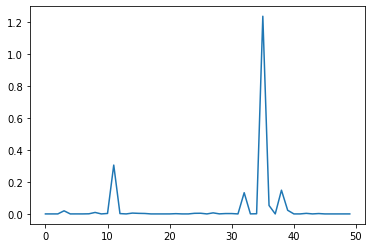

In [92]:
plt.plot(loss_arr)
plt.show()

In [93]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for image,label in testloader:
        x = image.to(device)
        y_= label.to(device)

        output = model.forward(x)  
        _,output_index = torch.max(output,1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 96.09375


In [94]:
PATH = './0804_after_gray.pth'
torch.save(model.state_dict(), PATH)

In [95]:
model = Resnet().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 228, 454)
(228, 454, 3)
GroundTruth:  damaged / no_damaged
Predicted:  damaged / damaged


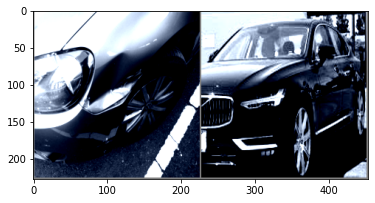

In [97]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' / '.join('%5s' % classes[labels[j]] for j in range(2)))

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' / '.join('%5s' % classes[predicted[j]]
                              for j in range(2)))